# HW3

### Jianing Sun

# 1. Autoencoder

A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of Dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should Be able to do better using convolutional layers instead of Dense layers.

Build and fit a convolutional autoencoder for the CIFAR10 dataset.</br>
The components of this network will be many of the same pieces we’ve used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will uti- lize UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this Post https://blog.keras.io/building-autoencoders-in-keras.html. DO NOT JUST COPY THIS CODE AND TURN IT IN. BE CREATIVE, COME UP WITH YOUR OWN VARIATION.

After training your network, visualize some examples of input images and their decoded reconstruction.

### data loading / preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
import keras
from keras import layers
tfkl = tfk.layers

In [2]:
data, info = tfds.load('cifar10', with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [3]:
data["train"]

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

In [4]:
preprocess = lambda d : ( tf.cast(d["image"],tf.float32)/255., d["label"])
ae_targets = lambda x,y: (x,x) #generate autoencoder targets
##data pipeline
ds_train = data["train"]\
            .map(preprocess)\
            .map(ae_targets)\
            .cache().batch(32).repeat().prefetch(5)

In [5]:
ds_train

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 32, 32, 3)), types: (tf.float32, tf.float32)>

next(iter(..)) gives us 1 batch, image size of 32*32, and every grid has 3 dim representing color

In preprocessing, convert (image,label) to (image,image) for autoencoder purpose, so no matter it's next(iter(...))[0] or next(iter(...))[1], they should be the same

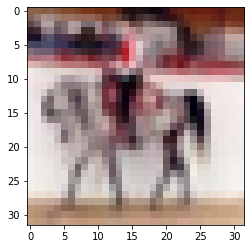

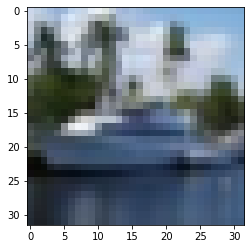

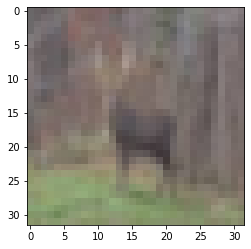

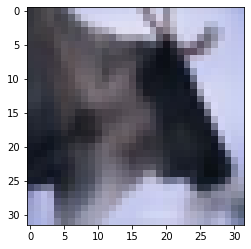

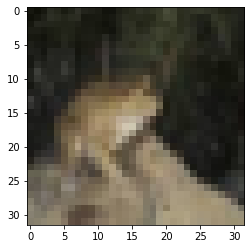

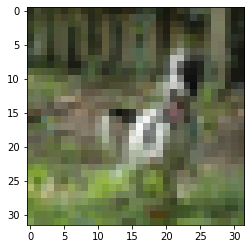

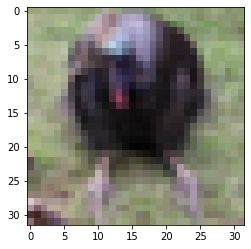

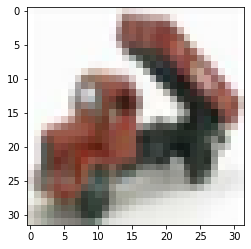

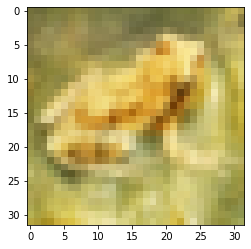

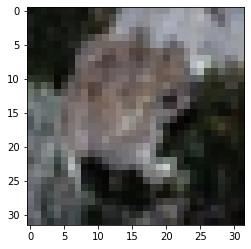

In [6]:
imgs = next(iter(ds_train))[0]
for i in range(10):
    plt.imshow(imgs[i])
    plt.show()

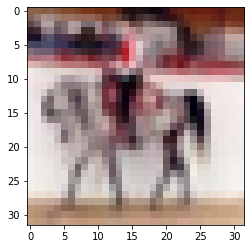

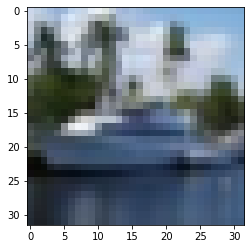

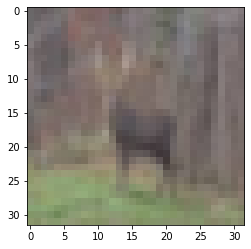

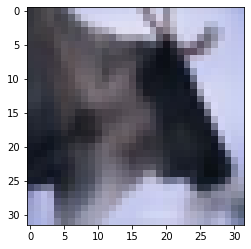

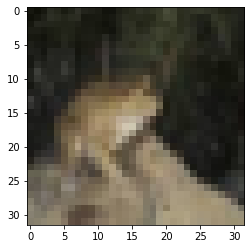

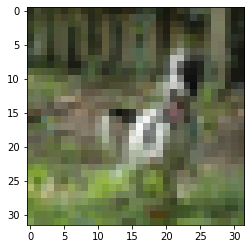

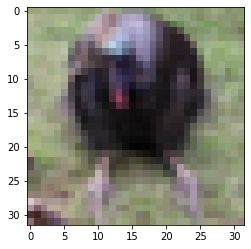

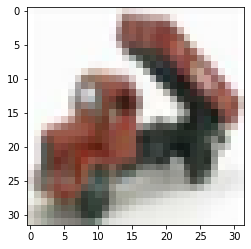

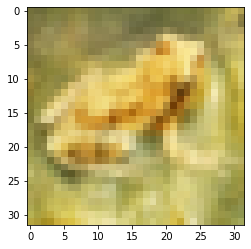

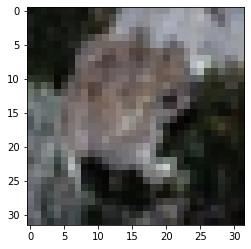

In [7]:
imgs = next(iter(ds_train))[1]
for i in range(10):
    plt.imshow(imgs[i])
    plt.show()

In [8]:
imgs.shape

TensorShape([32, 32, 32, 3])

### build encoder and decoder

In [9]:
img_shape = info.features['image'].shape
print(img_shape)
print(np.prod(img_shape))

(32, 32, 3)
3072


In [15]:
#encoder
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) 
#(filters,kernal_size,stride=(1,1),padding)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

In [37]:
#decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)# at this point the representation is (16, 16, 8)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(16, (3, 3), activation='relu')(x)
# why (16,16,8)->(14,14,16)?
## Firstly, filters=16, so the 3rd dim of output shape goes from 8->16.
## (16,16)->(14,14), because the kernal size is (3,3), and the stride is in default (1,1), and padding is in default "valid". 
## So at last step when 1 grid goes beyond limit, it will stop, so it's (16-2,16-2)=(14,14)
## However, if the kernal size is (3,3) and the stride is (3,3), padding="valid",
## Then (16,16)->(5,5)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='softmax', padding='same')(x)

In [38]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)          

In [39]:
autoencoder.compile(optimizer='adam',
    loss=tfk.losses.CategoricalCrossentropy(),metrics=["acc"])
# Here we use softmax's loss function: categorical crossentropy; but this means the multiple labels is an one-hot vector 
# - actually we are predicting a series of number which is not one-hot

In [40]:
autoencoder.fit(ds_train, steps_per_epoch=100, epochs=40)

Epoch 1/40
100/100 [==============================] - 4s 38ms/step - loss: 1.5537 - acc: 0.4700
Epoch 2/40
100/100 [==============================] - 4s 36ms/step - loss: 1.5542 - acc: 0.6127
Epoch 3/40
100/100 [==============================] - 3s 34ms/step - loss: 1.5412 - acc: 0.6257
Epoch 4/40
100/100 [==============================] - 3s 34ms/step - loss: 1.5374 - acc: 0.6380
Epoch 5/40
100/100 [==============================] - 3s 35ms/step - loss: 1.5465 - acc: 0.6421
Epoch 6/40
100/100 [==============================] - 3s 34ms/step - loss: 1.5553 - acc: 0.6468
Epoch 7/40
100/100 [==============================] - 3s 34ms/step - loss: 1.5381 - acc: 0.6448
Epoch 8/40
100/100 [==============================] - 3s 34ms/step - loss: 1.5468 - acc: 0.6485
Epoch 9/40
100/100 [==============================] - 3s 34ms/step - loss: 1.5448 - acc: 0.6552
Epoch 10/40
100/100 [==============================] - 3s 34ms/step - loss: 1.5499 - acc: 0.6566
Epoch 11/40
100/100 [==================

### visualize images and decoded reconstruction (using test-set)

In [42]:
x, y = next(iter(data['test'].map(preprocess).batch(1000)))

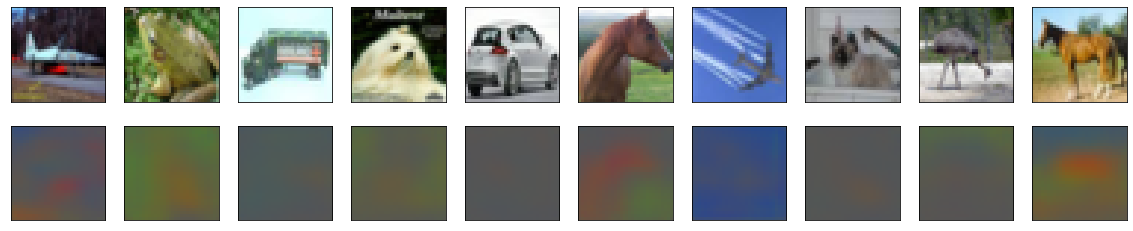

In [47]:
decoded_imgs = autoencoder.predict(x)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2. Image Classification

## 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the architectural choices you’ve made: kernel sizes, strides, padding, network depth.Train your network end-to-end. Report on your model’s performance on the training set and test set.

In [124]:
preprocess = lambda d : (tf.cast(d["image"],tf.float32)/255., tf.one_hot(d["label"],depth=10)) #convert y to one-hot vector
##data pipeline
ds_train = data["train"].map(preprocess).cache().batch(32).repeat() #add .repeat() so the input data size could be greater than steps * epochs
ds_test = data["test"].map(preprocess).cache().batch(32) #if you add .repeat() for test set, you need to identify validation_steps iin model.fit()
## https://stackoverflow.com/questions/58842925/when-passing-an-infinitely-repeating-dataset-you-must-specify-the-steps-per-ep

In [125]:
ds_train

<RepeatDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [126]:
tfkl = tfk.layers

In [136]:
# build CNN
model = tfk.Sequential()

#Block 1
model.add(tfkl.Conv2D(filters = 20, kernel_size=(3,3), strides=(3,3), padding="valid", activation='relu', input_shape=(32, 32, 3)))
#output shape: (32,32,3)->(10,10,20) #why is param=560?
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

#Block 2
model.add(tfkl.Conv2D(filters = 30, kernel_size=2, strides=1, 
                      padding="same", activation='relu'))
model.add(tfkl.UpSampling2D(size=(1, 2)))

#Block 3
model.add(tfkl.Conv2D(filters = 16, kernel_size=2, strides=1, 
                      padding="same", activation='sigmoid')) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

#Block 3
model.add(tfkl.Conv2D(filters = 8, kernel_size=2, strides=1, 
                      padding="valid", activation='tanh')) #smooth stride; padding: handle edges;
model.add(tfkl.UpSampling2D(size=(2, 2)))

#Flatten
model.add(tfkl.GlobalMaxPool2D())
model.add(tfkl.Dense(10, activation='softmax')) #10 classes

Model description

In [137]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 10, 10, 20)        560       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 5, 5, 20)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 5, 5, 20)          0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 5, 5, 30)          2430      
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 5, 10, 30)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 5, 10, 16)         1936      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 2, 5, 16)        

In [ ]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)

results = model.fit(ds_train, steps_per_epoch=150, epochs=5000, batch_size=32, validation_data=ds_test)
#steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of unique samples of your dataset divided by the batch size.

Model’s performance on the training set and test set are：
training set accuracy is 0.54
test set accuracy is 0.57

## 2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the major-
ity of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet, VGG, etc). Report on your model’s performance on the training set and test set.

In [139]:
from tensorflow.keras.applications import VGG16

In [140]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))

In [141]:
conv_base

In [142]:
model = tfk.Sequential()

model.add(conv_base)

model.add(tfkl.Flatten())

model.add(tfkl.Dense(10))

In [143]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


In [145]:
#take much time (already decrease the time by reducing steps_per_epoch and epochs)
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)

results = model.fit(ds_train, batch_size=32, steps_per_epoch=30, epochs=20,verbose=1)

Epoch 1/20
30/30 [==============================] - 16s 547ms/step - loss: 9.3469 - acc: 0.1042
Epoch 2/20
30/30 [==============================] - 17s 570ms/step - loss: 9.4862 - acc: 0.0917
Epoch 3/20
30/30 [==============================] - 17s 571ms/step - loss: 9.7044 - acc: 0.0979
Epoch 4/20
30/30 [==============================] - 17s 565ms/step - loss: 9.8388 - acc: 0.1042
Epoch 5/20
30/30 [==============================] - 18s 584ms/step - loss: 9.8723 - acc: 0.0917
Epoch 6/20
30/30 [==============================] - 17s 573ms/step - loss: 9.8723 - acc: 0.1031
Epoch 7/20
30/30 [==============================] - 17s 558ms/step - loss: 9.1336 - acc: 0.0875
Epoch 8/20
30/30 [==============================] - 17s 556ms/step - loss: 9.8052 - acc: 0.1052
Epoch 9/20
30/30 [==============================] - 17s 552ms/step - loss: 9.5198 - acc: 0.0969
Epoch 10/20
30/30 [==============================] - 17s 573ms/step - loss: 9.4190 - acc: 0.0948
Epoch 11/20
30/30 [====================

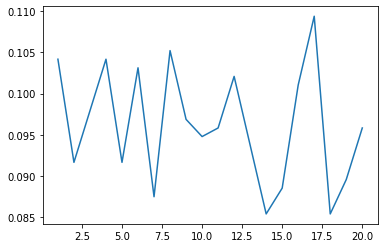

In [146]:
acc = results.history["acc"]
epochs = range(1,len(acc) + 1)
plt.plot(epochs,acc)

# 3. Text Classification

While images contain local spatial correlations and structure, many other datasets contain temporal correlations. Examples include time series and dis- crete sequences such as text. In this problem, we will tackle the task of text classification in the context of natural language.

**Background**. In this problem, we will build models that read text segments (messages) and identify whether they are SPAM or HAM.

Wikipedia describes **SPAM** as “the use of electronic messaging systems to send unsolicited bulk messages, especially advertising, indiscriminately.”

The term **‘HAM’** was originally coined by SpamBayes sometime around 2001 and is currently defined and understood to be “E-mail that is generally desired and isn’t considered SPAM.”

**Dataset**. The dataset consists of ∼ 5500 messages along with binary la- bels(SPAM or HAM) and is already preprocessed. So basically each sample is like **[MESSAGE, LABEL]**.

In [7]:
dt = pd.read_csv("SPAM_detection.csv")
print(dt.shape)
print(dt.columns)

(5572, 2)
Index(['Message', 'category_val'], dtype='object')


## 3.1 RNN

Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

### text preprocessing in word-level

In [152]:
# use word-level RNN in comparison with character-level in CNN

In [8]:
import string
def text_processing(input_str):
    input_str = input_str.lower() #convert to lower case
    #remove punctuation
    for punc in input_str:  
        if punc in string.punctuation:
            input_str = input_str.replace(punc, "") 
    input_str = " ".join(input_str.split())
    return input_str.split()

In [9]:
dt["processing_txt"] = dt["Message"].map(text_processing)

In [10]:
dt.head(5)

,Message,category_val,processing_txt
0,"Go until jurong point, crazy.. Available only ...",0,"[go, until, jurong, point, crazy, available, o..."
1,Ok lar... Joking wif u oni...,0,"[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,U dun say so early hor... U c already then say...,0,"[u, dun, say, so, early, hor, u, c, already, t..."
4,"Nah I don't think he goes to usf, he lives aro...",0,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [11]:
wrds = sorted(list(set(dt["processing_txt"].apply(pd.Series).stack().reset_index(drop=True))))
print('total words:', len(wrds))
wrds_indices = dict((c, i) for i, c in enumerate(wrds))
indices_wrds = dict((i, c) for i, c in enumerate(wrds))

total words: 9657


In [12]:
txt_len = len(dt["processing_txt"])
maxlen = max(dt["processing_txt"].map(len))
print("how many messages in total:",txt_len)
print("max length of words in each message:",maxlen)

how many messages in total: 5572
max length of words in each message: 171


In [13]:
X = np.zeros((txt_len, maxlen, len(wrds)), dtype=np.uint8)
for j in range(0,txt_len):
    for i,wrd in enumerate(dt["processing_txt"][j]):
        X[j, i, wrds_indices[wrd]] = 1
X.shape

(5572, 171, 9657)

In [14]:
print(X[0,0,:])
print(dt["category_val"][0])

[0 0 0 ... 0 0 0]
0


### split training set and test set

In [48]:
import random
train_ix = random.sample(range(0, txt_len), int(txt_len*0.6))
test_ix = list(set(range(0, txt_len)) - set(train_ix))

In [51]:
print(len(train_ix))
print(len(test_ix))

3343
2229


In [52]:
train = X[train_ix,:,:]
test = X[test_ix,:,:]
label_train = dt["category_val"][train_ix]
label_test = dt["category_val"][test_ix]

In [53]:
print(train.shape)
print(test.shape)
print(label_train.shape)
print(label_test.shape)

(3343, 171, 9657)
(2229, 171, 9657)
(3343,)
(2229,)


### Build LSTM-RNN for classifying SPAM/HAM

In [54]:
rnn = tfk.Sequential()
rnn.add(tfkl.LSTM(128, input_shape=(maxlen, len(wrds))))
rnn.add(tfkl.Dense(1,activation="sigmoid"))

In [55]:
rnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               5010432   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 5,010,561
Trainable params: 5,010,561
Non-trainable params: 0
_________________________________________________________________


In [56]:
rnn.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.01),metrics=["acc"])

In [57]:
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.01,patience=2)]
ds_train = tf.data.Dataset.from_tensor_slices((train,label_train)).batch(32).repeat().prefetch(10) 
ds_test = tf.data.Dataset.from_tensor_slices((test,label_test)).batch(32).repeat().prefetch(10) 

In [58]:
rnn_result = rnn.fit(ds_train, steps_per_epoch=10,epochs=20,callbacks=cbs,verbose=1,validation_data=ds_test,validation_steps=1)

Epoch 1/20
10/10 [==============================] - 15s 2s/step - loss: 0.6486 - acc: 0.8500 - val_loss: 0.6219 - val_acc: 0.7188
Epoch 2/20
10/10 [==============================] - 14s 1s/step - loss: 0.4584 - acc: 0.8313 - val_loss: 0.6468 - val_acc: 0.7188
Epoch 3/20
10/10 [==============================] - 14s 1s/step - loss: 0.3840 - acc: 0.8750 - val_loss: 0.7992 - val_acc: 0.7188


## 3.2 CNN

Build and train a 1D CNN for this text classification task. We recommend you do a character-level convolution (with character embeddings). You might gain some insight and inspiration from these text classification approaches:

1.http://www.aclweb.org/anthology/D14-1181

2.https://arxiv.org/abs/1702.08568

Tips: after splitting every character in each training sample, the maximum length of training samples can be really big. If you choose to only do the padding trick to all the samples, it might raise OOM issues. So instead of padding only, you can also cut each sample at a certain point, which can make training more efficient and feasible while using CNN.

In [27]:
tfkl = tfk.layers

In [28]:
cnn = tfk.Sequential()
cnn.add(tfkl.Conv2D(filters = 1, kernel_size=(2,5), strides=(2,5), 
                      padding="valid", activation='relu', input_shape=(maxlen, len(wrds),1))) #be cautious of the input: should be "each" message
## https://stackoverflow.com/questions/47665391/keras-valueerror-input-0-is-incompatible-with-layer-conv2d-1-expected-ndim-4
cnn.add(tfkl.Dropout(.2))
cnn.add(tfkl.MaxPool2D(pool_size=(3,3)))
cnn.add(tfkl.Conv2D(filters = 1, kernel_size=(3,1), strides=(10,10), 
                      padding="valid", activation='tanh'))
#tfkl.GlobalMaxPool2D() works like Flatten()
cnn.add(tfkl.Flatten())
cnn.add(tfkl.Dense(1, activation='sigmoid'))

In [29]:
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 85, 1931, 1)       11        
_________________________________________________________________
dropout_2 (Dropout)          (None, 85, 1931, 1)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 643, 1)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 65, 1)          4         
_________________________________________________________________
flatten_2 (Flatten)          (None, 195)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 196       
Total params: 211
Trainable params: 211
Non-trainable params: 0
________________________________________________________

In [35]:
cnn.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=["acc"]
)

In [66]:
#reshape cnn input!
## Be cautious of the input: should be "each" message
## https://stackoverflow.com/questions/47665391/keras-valueerror-input-0-is-incompatible-with-layer-conv2d-1-expected-ndim-4
x_cnn_train = train.reshape(len(train_ix), maxlen, len(wrds),1)
label_cnn_train = np.array(label_train)
###
x_cnn_test = test.reshape(len(test_ix), maxlen, len(wrds),1)
label_cnn_test = np.array(label_test)
###
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.01,patience=2)]
ds_train = tf.data.Dataset.from_tensor_slices((x_cnn_train,label_cnn_train)).batch(32).repeat().prefetch(10) 
ds_test = tf.data.Dataset.from_tensor_slices((x_cnn_test,label_cnn_test)).batch(32).repeat().prefetch(10) 

In [67]:
cnn_result = cnn.fit(ds_train, steps_per_epoch=10,epochs=20,callbacks=cbs,verbose=1,validation_data=ds_test,validation_steps=1)

Epoch 1/20
10/10 [==============================] - 5s 502ms/step - loss: 0.4248 - acc: 0.8500 - val_loss: 0.6558 - val_acc: 0.7188
Epoch 2/20
10/10 [==============================] - 6s 575ms/step - loss: 0.4554 - acc: 0.8313 - val_loss: 0.6428 - val_acc: 0.7188
Epoch 3/20
10/10 [==============================] - 5s 505ms/step - loss: 0.3795 - acc: 0.8750 - val_loss: 0.6669 - val_acc: 0.7188
Epoch 4/20
10/10 [==============================] - 5s 473ms/step - loss: 0.3356 - acc: 0.8969 - val_loss: 0.6939 - val_acc: 0.7188


## 3.3 Validation plot OR ROC Curve

Be sure to directly compare your two methods with an ROC curve or similar validation method. Don’t forget to create a train-test split.

Here I use loss plot to for validation.

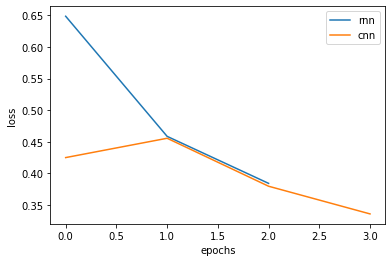

In [69]:
plt.plot(rnn_result.history["loss"])
plt.plot(cnn_result.history["loss"])
plt.legend(labels=["rnn", "cnn"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()